## Spam or Ham classification using RNN and LSTM

In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [2]:
# %tensorflow_version 2.xb
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
tf.__version__

'2.16.1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ML3/' #replace this with your directory path if working in collab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('email_classification.csv') #use this if working in local
df.head(5)

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


Above is a sample of the data, it contains two features. The mail itself and the classification of it.

In [4]:
df = pd.read_csv(data_dir + 'email_classification.csv')
df['num_label'] = df.label.map({'spam':1,
                                'ham':0})

these are rudimentary steps in our data preparation. We map the labels to either 1 or 0  

## Setting a baseline

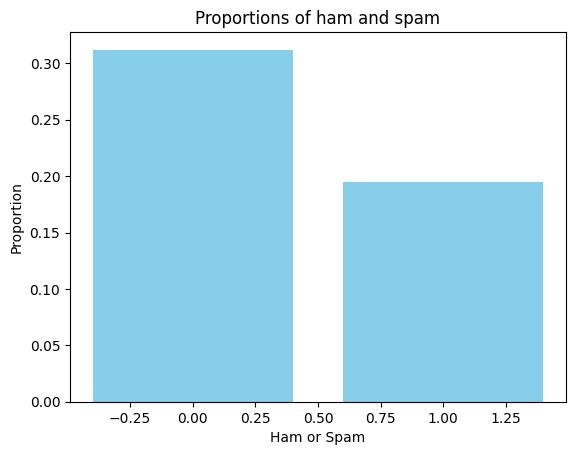

Proportion Chance Criterion = 50.6881807683905%
1.25*Proportion Chance Criterion = 63.36022596048812%


In [63]:
df['num_label'].value_counts()
num = (df.groupby('num_label').size() /
       df.groupby('num_label').size().sum())**2
PCC = num.sum()
plt.bar(num.index, num, color='skyblue')
plt.xlabel('Ham or Spam')
plt.ylabel('Proportion')
plt.title('Proportions of ham and spam')
plt.show()
print("Proportion Chance Criterion = {}%".format(100*PCC))
print("1.25*Proportion Chance Criterion = {}%".format(1.25*100*PCC))

Here we are setting our baseline, from the baseline it is clear that the model we make, needs to be atleast better than 63% accuracy.

In [5]:
outcomes = np.array(df.num_label)
mails = np.array(df.email)

In this step, we are converting our individual emails into an array, this then will be put through a tokenizer, helping us move forward.

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [7]:
token = Tokenizer(lower = True, num_words = 10000)
token.fit_on_texts(mails)
sequences = token.texts_to_sequences(mails)

Here we are fitting a tokenizer object on our text data. This will process the text data and start building our vocab library. Following that we are converting our data into a sequence of integers by using the vocan library built by the Tokenzier

In [8]:
max = 0
for length in sequences:
  if len(length) > max:
    max = len(length)
print(max)

19


In the above cell, the code we wrote helps us find the maxlen that will be used while padding our tokens.


In [9]:
input_mails = pad_sequences(sequences, maxlen = 19)

In [10]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(input_mails, outcomes, train_size = 0.8)


In [11]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense

model = Sequential()
model.add(Embedding(input_dim = 1000, output_dim = 32))
model.add(SimpleRNN(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))



In the above, one will notice the inclusion of the dropout layer. This has been introduced to help with regularization. While creating this notebook, we ran the code without a dropout and saw quite some overfitting. To combat this we decided to include the dropout layer and to ensure we aren't regularizing it too much, we put the value at a 0.3

In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 20, batch_size = 20, validation_split = 0.15)

Epoch 1/20
7/7 [==============================] - 10s 287ms/step - loss: 0.6763 - acc: 0.5372 - val_loss: 0.7038 - val_acc: 0.3636
Epoch 2/20
7/7 [==============================] - 1s 181ms/step - loss: 0.5765 - acc: 0.8264 - val_loss: 0.6508 - val_acc: 0.5455
Epoch 3/20
7/7 [==============================] - 1s 199ms/step - loss: 0.4610 - acc: 0.9256 - val_loss: 0.5855 - val_acc: 0.6818
Epoch 4/20
7/7 [==============================] - 2s 327ms/step - loss: 0.3534 - acc: 1.0000 - val_loss: 0.5603 - val_acc: 0.7273
Epoch 5/20
7/7 [==============================] - 1s 147ms/step - loss: 0.2476 - acc: 1.0000 - val_loss: 0.3873 - val_acc: 0.8182
Epoch 6/20
7/7 [==============================] - 1s 109ms/step - loss: 0.1738 - acc: 1.0000 - val_loss: 0.4564 - val_acc: 0.7273
Epoch 7/20
7/7 [==============================] - 2s 251ms/step - loss: 0.1178 - acc: 1.0000 - val_loss: 0.2270 - val_acc: 0.9091
Epoch 8/20
7/7 [==============================] - 1s 198ms/step - loss: 0.0896 - acc: 1.0

In [13]:
test_acc = model.evaluate(x_test, y_test)


2/2 [==============================] - 0s 11ms/step - loss: 0.1024 - acc: 0.9444


The above shows us that we have gotten a 94% test accuracy, while this may seem amazing, it is important to check if the model is actually this good.

In [48]:
from sklearn.metrics import precision_score, recall_score

y_pred = model.predict(x_test)

2/2 [==============================] - 0s 9ms/step


In [15]:
y_pred_binary = (y_pred > 0.5).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

In [16]:
print(precision)
print(recall)

0.8571428571428571
1.0


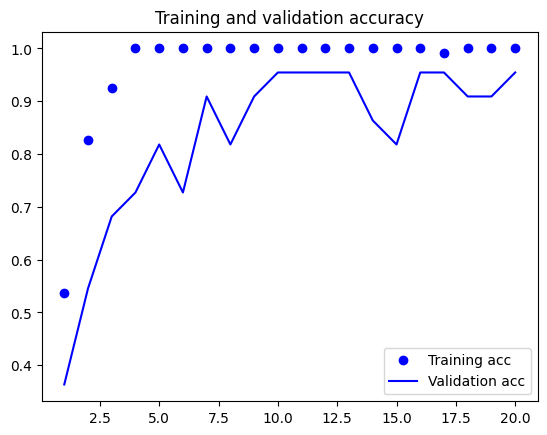

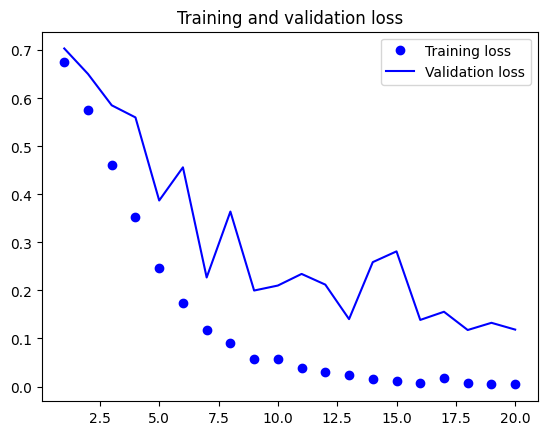

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In the above, we can see that some degree of overfitting still exists in our data. The model is learning extremely well on the training data but not as good on the validation.

## LSTM

In [55]:
model1 = Sequential()
model1.add(Embedding(input_dim = 1000, output_dim = 32))
model1.add(LSTM(32))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation = 'sigmoid'))


similar to the RNN, we have included a dropout layer for the same reason as stated above.

In [56]:
model1.compile(optimizer = 'rmsprop', metrics = ['acc'],loss= 'binary_crossentropy')
history1 = model1.fit(X_train, y_train, epochs = 20, batch_size = 20, validation_split = 0.15 )

Epoch 1/20
7/7 [==============================] - 3s 149ms/step - loss: 0.6907 - acc: 0.6033 - val_loss: 0.6982 - val_acc: 0.2273
Epoch 2/20
7/7 [==============================] - 0s 44ms/step - loss: 0.6799 - acc: 0.5537 - val_loss: 0.6866 - val_acc: 0.5455
Epoch 3/20
7/7 [==============================] - 0s 41ms/step - loss: 0.6646 - acc: 0.8595 - val_loss: 0.6782 - val_acc: 0.5455
Epoch 4/20
7/7 [==============================] - 0s 54ms/step - loss: 0.6334 - acc: 0.8264 - val_loss: 0.6415 - val_acc: 0.7727
Epoch 5/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5801 - acc: 0.9339 - val_loss: 0.6110 - val_acc: 0.7273
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4797 - acc: 0.9421 - val_loss: 0.5989 - val_acc: 0.7273
Epoch 7/20
7/7 [==============================] - 0s 54ms/step - loss: 0.3543 - acc: 0.9339 - val_loss: 0.5883 - val_acc: 0.7273
Epoch 8/20
7/7 [==============================] - 0s 23ms/step - loss: 0.2551 - acc: 0.9587 - va

O

In [57]:
model1.evaluate(x_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0608 - acc: 1.0000


[0.06084230914711952, 1.0]

In [58]:
y_pred_lstm = model1.predict(x_test)

y_pred_binary_lstm = (y_pred_lstm >0.5).astype(int)

pres = precision_score(y_test, y_pred_binary_lstm)
rec = recall_score(y_test, y_pred_binary_lstm)

2/2 [==============================] - 0s 6ms/step


In [59]:
print(pres)
print(rec)

1.0
1.0


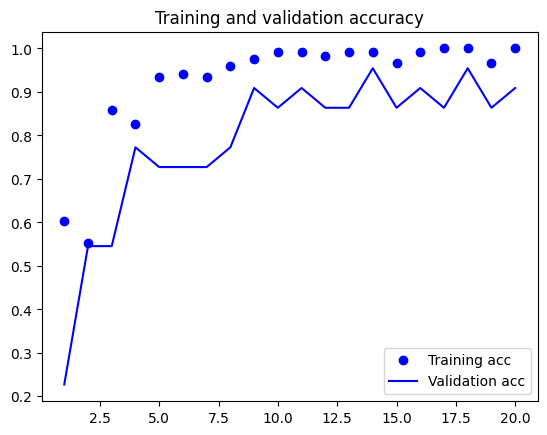

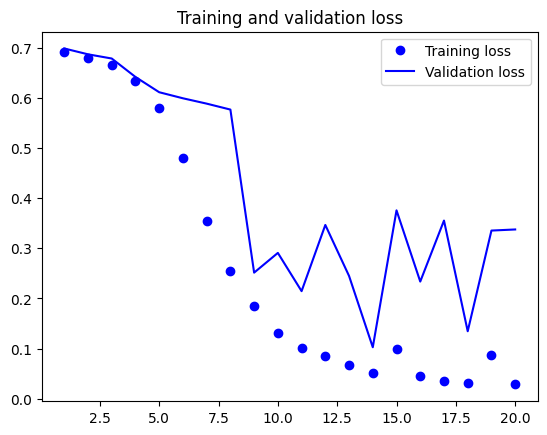

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## DISCUSSION, FINDINGS AND CONCLUSION



| Model   | Train Accuracy | Val Accuracy | Test Accuracy | Precision | Recall |
|---------|----------------|--------------|---------------|-----------|--------|
| RNN     | 100%          | 95.25%      | 94.4%      | 0.85     | 1   |
| LSTM  | 100%      | 95.45%       | 100%          | 1      | 1   |


**methodology**
  
a standard RNN  and LSTM model was used, but to explore more and aid in model performance,a Dropout layer was added to regularise. Initially, I quite interested in knowing how model output would change with a change in the activation parameter, Since adam uses adaptive learning rates and  converges faster, I thought using this would yeild a more effecient model. But after reading https://www.ej-compute.org/index.php/compute/article/download/80/37/307 , it was made clear that the rmsprop was the better function to use in this case. Following that I computed test scores, precision and recall and printed graphs to help compare the models better.


**Model comparison**
    
 While both the models performed similarly, I feel that the degree of overfitting was lesser on LSTM than its counterpart. LSTM performs bettern than RNN in almost all aspects and even has a higher precision and recall score. When it comes to test accuracy, the LSTM model has a perfect 100% compared to 94.4 of that of the RNN model. When it comes to run time, since the dataset is so small, comparisons can't really be made in the avenue. Overall, I believe that the LSTM model is the better one of the two in this case.

**observations**
    
1) Every time the split of the data was done, the accuracy for val and test kept changing. Maybe this could mean that a more thorough splitting will help us gauge the model better. Using something like a stratifiedkfold could be something to look into here, ensuring more exposure of the data.

2) Using the models without the dropout while training showed a greater degree of overfitting than when we trained the model with the dropout, this indicates that dropout does help with regularization.



